# Random Forest
A thorough explanation of random forests can be found [here](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(42)

In [2]:
# Prints the metrics that we're going to use to evaluate classifier performance.
def my_test_results(model, X, Y):
    cm = confusion_matrix((Y == 1), (model.predict(X) > 0.5), labels=[0, 1])
    accuracy = (cm[0, 0] + cm[1, 1])/sum(sum(cm))
    precision = float(cm[1, 1]/(cm[1, 1]+cm[0, 1]))
    recall = float(cm[1, 1]/(cm[1, 1]+cm[1, 0]))
    f1 = (2.0 * precision*recall)/(precision+recall)
    print("Out of sample accuracy = %4.3f" % accuracy)
    print("Out of sample precision = %4.3f" % precision)
    print("Out of sample recall = %4.3f" % recall)
    print("Out of sample F1 = %4.3f" % f1)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])

### Import Data

* Load data
* Remove useless columns and records (only CASH_OUT and TRANSFER have fraud).
* Remap transfer to 0/1.

In [3]:
df = pd.read_csv('../simulated_transactions.csv.xz')
print(df.shape)
df.head()

(1305514, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2,PAYMENT,18211.33,C1099717276,88.00,0.00,M417557780,0.00,0.00,0,0
1,2,CASH_IN,93240.07,C1350751778,47.00,93287.07,C665576141,12.00,8650239.39,0,0
2,2,CASH_IN,78314.86,C332699949,93287.07,171601.93,C1359044626,178957.00,16435074.66,0,0
3,2,CASH_IN,101282.39,C808417649,171601.93,171601.93,C1599771323,171601.93,3771328.56,0,0
4,2,CASH_IN,24227.29,C858204589,171601.93,195829.22,C353842779,524999.00,872623.24,0,0


#### Description
From the above we can see we read in a total of over 6 million records with 11 columns.
<br>The description of the 11 columnes follows:

|Variable|Description|Keep|
| :------| :---------| :--|
|step|Maps a unit of time in the real world. In this case 1 step is 1 hour of time.|Drop|
|type|CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER|Keep (TRANSFER and CASH-OUT)|
|amount|The amount of the transaction.|Keep|
|nameOrig|The customer ID for the initiator of the transaction.|Drop|
|oldbalanceOrg|The initial balance before the transaction.|Keep|
|newbalanceOrg|The customer's balance after the transaction.|Keep|
|nameDest|The customer ID for the recipient of the transaction.|Drop|
|oldbalanceDest|The initial recipient balance before the transaction.|Keep|
|newbalanceDest|The recipient's balance after the transaction.|Keep|
|isFraud|This identifies a fraudulent transaction (1) and non fraudulent transaction(0).|Keep|
|isFlaggedFraud|This is a rule based system that flags illegal attempts to transfer more than 200.000 in a single transaction.|Drop|

### Filtering
Filter out types other than TRANSFER, and CASH_OUT.<br>
Remove variables, 'step', 'nameOrig', 'nameDest', and 'isFlaggedFraud'.

In [4]:
X = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'],
            axis=1).query('type == "CASH_OUT" or type == "TRANSFER"')
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
print(X.shape)

(586965, 7)


### Data Exploration
Normally data exploration would be done here. Looking at the data ranges, distributions and relationships. See the Data Exploration section for examples of this. For the purpose the this notebook we will skip straight to the logistic regression.

## Random Forest Classifier
Begin preparing for the model

### Training Set
Partition the data with an 80/20 split: Training/Testing. <br>
Separate out the dependent variable from the independent varaibles.

In [5]:
train, test = train_test_split(X, test_size=0.2, stratify=X['isFraud'])

Y_train = train['isFraud']
X_train = train.drop(['isFraud'], axis=1)

Y_test = test['isFraud']
X_test = test.drop(['isFraud'], axis=1)

In [6]:
rf = RandomForestClassifier(n_estimators=200, criterion="entropy",
                            n_jobs=8, max_features=5, oob_score=True)
rf = rf.fit(X_train, Y_train)

Out of sample accuracy = 0.999
Out of sample precision = 0.996
Out of sample recall = 0.945
Out of sample F1 = 0.970


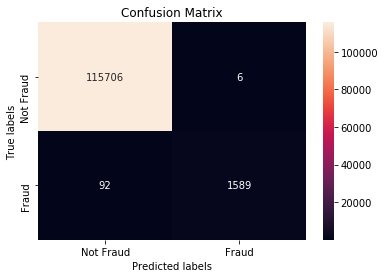

In [7]:
mymodel = RandomForestClassifier()

dt = mymodel.fit(X_train, Y_train)
my_test_results(dt, X_test, Y_test)

* Accuracy - Proportion of predictions that are correct. $\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}$
* Precision - True positive over total positive actual cases. $\frac{True Positive}{True Positive + False Positive}$
* Recall - True positive over total positive predicted cases. $\frac{True Positive}{True Positive + False Negative}$
* F1 - A balance between Precision and Recall (harmonic mean of precision and recall) $\frac{2 * Precision * Recall}{Precision + Recall}$

That's not bad. <br>
It's not as easy for to see the interactions are a single tree, but as black box as some other approaches.<br>
The feature importance is as follows:

In [8]:
fi = pd.DataFrame({"value": rf.feature_importances_})
fi['feature_name'] = pd.DataFrame(X_train.columns)
fi

,value,feature_name
0,0.068556,type
1,0.065130,amount
2,0.627891,oldbalanceOrg
3,0.108152,newbalanceOrig
4,0.017148,oldbalanceDest
5,0.113122,newbalanceDest


### Summary
A random forrest is a good brute force choice for a model. It's resistent to overfitting and does not have require a lot of tuning to return decent results. It requires a lot of computation, but parallelizes easy. A good choice if you have more CPU time than people time and are fine with "good" but not "great".